In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import time
import json

options = Options()
options.headless = True

driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager().install()))

[WDM] - Downloading: 100%|██████████| 6.29M/6.29M [00:00<00:00, 6.88MB/s]


In [48]:
def scrape_match_event(driver, match_id):
    match_url = f'https://www.fotmob.com/match/{match_id}'
    match_id = match_url.split('/')[4]
    driver.get(match_url)

    club_div = driver.find_elements(
        By.CSS_SELECTOR, '.e3q4wbq3 a .e3q4wbq4 span')
    club_id_div = driver.find_elements(By.CSS_SELECTOR, '.e3q4wbq3 a')
    club_name = [club_div[0].get_attribute(
        'innerHTML'), club_div[1].get_attribute('innerHTML')]
    club_id = [club_id_div[0].get_attribute('href').split(
        '/')[4], club_id_div[1].get_attribute('href').split('/')[4]]
    clubs = pd.DataFrame({'club_id': club_id, 'club_name': club_name})

    data = driver.find_elements(By.CSS_SELECTOR, '#__NEXT_DATA__')
    jstring = data[0].get_attribute('innerHTML')
    obje = json.loads(jstring)
    shots = obje['props']['pageProps']['initialState']['matchFacts']['data']['content']['shotmap']['shots']
    match_events = []
    for s in shots:        
        if int(s['teamId']) == int(club_id[0]):
            venue = 'H'
        else:
            venue = 'A'
        event = {
            'teamId': s['teamId'],
            'teamName': clubs[clubs['club_id'] == str(s['teamId'])]['club_name'].iloc[0],
            'playerId': s['playerId'],
            'playerName': s['playerName'],
            'min': s['min'],
            'xG': s['expectedGoals'],
            'eventType': s['eventType'],
            'teamColor': s['teamColor'],
            'match_id': match_id,
            'isOwnGoal': s['isOwnGoal'],
            'x': s['x'],
            'y': s['y'],
            'situation': s['situation'],
            'venue' : venue,
        }
        match_events.append(event)

        min = s['min']
        playerName = s['playerName']
        eventType = s['eventType']

        print(f'{min}\' {playerName} {eventType}')
    match_events_df = pd.DataFrame(match_events)
    return match_events_df


In [75]:
def draw_lollipop_chart(match_data):
    match_df = match_data.copy()
    match_df['min'] = match_df['min'].astype(int)
    match_df['xG'] = match_df['xG'].astype(float)

    match_df = match_df.sort_values(
        by='min', ascending=True).reset_index(drop=True)

    home_conditional = (match_df['venue'] == 'H')
    away_conditional = (match_df['venue'] == 'A')

    fig = plt.figure(figsize=(5, 2), dpi=200)
    ax = plt.subplot(111)

    ax.set_ylim(-1.05, 1.05)
    ax.set_xlim(-5, 95)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks(
        [x for x in range(-2, 45, 10)] + [x for x in range(52, 102, 10)],
        labels=[x for x in range(0, 91, 10)]
    )
    ax.tick_params(labelsize=7)

    plt.rcParams['hatch.linewidth'] = .45

    home_color = match_df[home_conditional]['teamColor'].iloc[0]
    try:
        away_color = match_df[away_conditional]['teamColor'].iloc[0]
    except:
        away_color = '#efefef'
        print('no away shot')

    for index, shot in enumerate(match_df[home_conditional]['xG']):
        ec_ = home_color
        marker = 'o'
        minute = match_df[home_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        if match_df[home_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
            ax.scatter([minute + offset_x], [shot + .025], marker=marker,
                       s=20, hatch=hatch, color='white', zorder=3, lw=1.15, ec=ec_)
        else:
            hatch = '/////////////'
            marker = 'o'
            if match_df[home_conditional]['isOwnGoal'].iloc[index]:
                shot = -1*shot
                ec_ = away_color
                marker = '^'
            ax.scatter([minute+offset_x], [shot+.025], marker=marker,
                       s=40, hatch=hatch, color='white', zorder=4, lw=1.15, ec=ec_)
            ax.annotate(
                xy=(minute+offset_x, shot+.15),
                text=f"{(match_df[home_conditional]['playerName'].iloc[index]).split(' ')[-1]}",
                size=5,
                weight='bold',
                font="DM Sans",
                zorder=10,
                ha='center'
            )
            if match_df[home_conditional]['situation'].iloc[index] == 'Penalty':
                ax.annotate(
                    xy=(minute+offset_x, (shot+.05)),
                    text='P',
                    size=5,
                    weight='bold',
                    zorder=8,
                    color='#000',
                    ha='center'
                )
        ax.plot([minute + offset_x, minute+offset_x],
                [0, shot], color=ec_, zorder=2)

    for index, shot in enumerate(match_df[away_conditional]['xG']):
        ec_ = away_color
        marker = 'o'
        minute = match_df[away_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        if match_df[away_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
            ax.scatter([minute + offset_x], [-1*shot - .025], marker=marker, s=20, hatch=hatch,
                       color="white", zorder=3, lw=1.15, ec=ec_)
        else:
            hatch = '/////////////'
            marker = 'o'
            if match_df[away_conditional]['isOwnGoal'].iloc[index]:
                shot = -1*shot
                ec_ = home_color
                marker = 'v'
            ax.scatter([minute + offset_x], [-1*shot - .025], marker=marker, s=40, hatch=hatch,
                       color="white", zorder=4, lw=1.15, ec=ec_)
            ax.annotate(
                xy=(minute+offset_x, -1*(shot+.15)),
                text=f"{(match_df[away_conditional]['playerName'].iloc[index]).split(' ')[-1]}",
                size=5,
                weight='bold',
                font="DM Sans",
                zorder=10,
                ha='center'
            )
            if match_df[away_conditional]['situation'].iloc[index] == 'Penalty':
                ax.annotate(
                    xy=(minute+offset_x, -1*(shot+.05)),
                    text='P',
                    size=5,
                    weight='bold',
                    zorder=8,
                    color='#000',
                    ha='center'
                )
        ax.plot([minute + offset_x, minute + offset_x],
                [0, -1*shot], color=ec_, zorder=2)

    ax.plot([-5, 95], [0, 0], color='black', lw=1.75)
    ax.plot([45, 45], [-1.05, 1.05], color='white', lw=1.75, zorder=2)
    ax.fill_between(
        x=[-5, 95], y1=[0], y2=[1.05],
        color=home_color, alpha=.1, zorder=1,
        hatch='++++++'
    )
    ax.fill_between(
        x=[-5, 95], y1=[0], y2=[-1.05],
        color=away_color, alpha=.1, zorder=1,
        hatch='++++++'
    )
    # *+-./OX\ox|
    home_team_id = match_df[home_conditional]['teamId'].iloc[0]
    away_team_id = match_df[away_conditional]['teamId'].iloc[0]
    home_team_name = match_df[home_conditional]['teamName'].iloc[0]
    away_team_name = match_df[away_conditional]['teamName'].iloc[0]

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # Native data to normalized data coordinates
    def DC_to_NFC(x): return FC_to_NFC(DC_to_FC(x))

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

    ax_coords = DC_to_NFC([-2, .55])
    logo_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], 0.15, 0.15], anchor='W')
    club_icon = Image.open(urllib.request.urlopen(
        f'{fotmob_url}{home_team_id:.0f}.png'))
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    ax_coords = DC_to_NFC([-2, -.9])
    logo_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], 0.15, 0.15], anchor='W')
    club_icon = Image.open(urllib.request.urlopen(
        f'{fotmob_url}{away_team_id:.0f}.png'))
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    home_xG = match_df[home_conditional & (
        match_df['isOwnGoal'] == False)]['xG'].sum()
    away_xG = match_df[away_conditional & (
        match_df['isOwnGoal'] == False)]['xG'].sum()
    home_goals = (match_df[home_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum(
    ) + (match_df[away_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()
    away_goals = (match_df[away_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum(
    ) + (match_df[home_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()

    ax.annotate(
        xy=(0.02, 1.05),
        text=f'{home_team_name} ({home_xG:.1f}) vs. {away_team_name} ({away_xG:.1f}): {home_goals} - {away_goals}',
        xycoords='axes fraction',
        weight='bold',
        size=9, font="DM Sans"
    )


In [ ]:
# df = pd.read_csv('../../data/soc/ligue1_shots.csv', index_col=0)
df = pd.read_csv('../../data/shots/epl_shots_2223.csv', index_col=0)
df['min'] = df['min'].astype(int)
df['xG'] = df['xG'].astype(float)
match_id = 3900941
data = df[df['match_id']==match_id].reset_index(drop=True)

8' Erling Braut Haaland Miss
12' Joao Cancelo AttemptSaved
12' Jack Grealish Miss
15' Kevin De Bruyne Miss
19' Kevin De Bruyne Miss
20' Erling Braut Haaland Goal
26' Erling Braut Haaland AttemptSaved
30' Kevin De Bruyne Miss
32' Marcos Acuna Miss
37' Erling Braut Haaland AttemptSaved
40' Alejandro Gomez Miss
49' Kevin De Bruyne AttemptSaved
49' Erling Braut Haaland Miss
51' Joao Cancelo Miss
53' Rodri Miss
58' Phil Foden Goal
62' Erling Braut Haaland Miss
64' Rafa Mir Miss
65' Alejandro Gomez AttemptSaved
65' Nemanja Gudelj Miss
67' Phil Foden AttemptSaved
67' Erling Braut Haaland Goal
72' Kevin De Bruyne AttemptSaved
73' Rodri Miss
74' Joao Cancelo AttemptSaved
75' Joao Cancelo Miss
82' Suso AttemptSaved
90' Cole Palmer AttemptSaved
90' Julián Álvarez AttemptSaved
90' Ruben Dias Goal


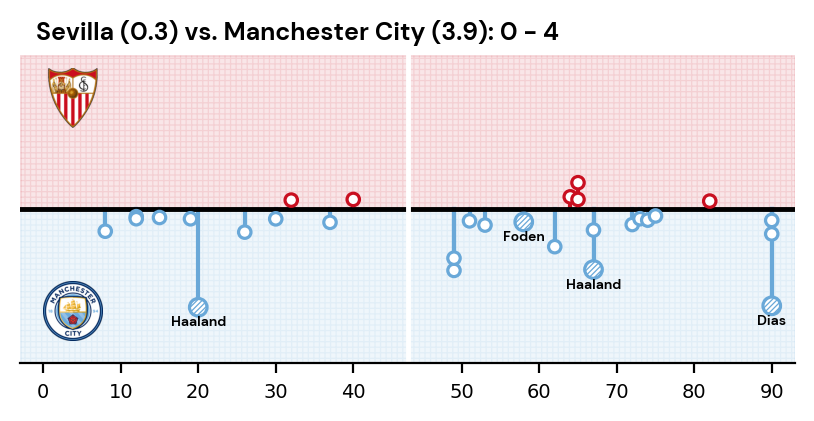

In [89]:
data = scrape_match_event(driver,4010157)
draw_lollipop_chart(data)